In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

from utils.data import DEFAULT_FLOAT_TYPE, TIME_COLUMN, load_data_with_features

In [2]:
def plot_anomalies(ts: pd.DataFrame, a: pd.DataFrame, y_column: str, title: str):
    fig, ax = plt.subplots(figsize=(18,9))

    start_t = ts.index[0]
    end_t = ts.index[-1]
    ax.plot(
        ts.loc[(ts.index >= start_t) & (ts.index <= end_t), TIME_COLUMN],
        ts.loc[(ts.index >= start_t) & (ts.index <= end_t), y_column],
        color="blue",
        label="Normal",
        zorder=5
    )
    ax.scatter(
        a.loc[(a.index >= start_t) & (a.index <= end_t), TIME_COLUMN],
        a.loc[(a.index >= start_t) & (a.index <= end_t), y_column],
        color="red",
        label="Anomaly",
        s=5,
        zorder=10
    )
    plt.xlabel("Date Time Integer")
    plt.ylabel(y_column)
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
y_column, x_columns, ts, useless_rows = load_data_with_features(
    "real_counts.db", is_csv=False, detailed_seasonality=False, extra_features=False
)
ts.describe()

,t,count,hour_of_day,day_of_week,month_of_year
count,4.794000e+03,4794.000000,4794.000000,4794.000000,4794.0
mean,1.623776e+09,14.295160,13.833751,1.993951,6.0
std,5.119805e+05,12.975232,4.664959,1.603565,0.0
min,1.622805e+09,0.000000,0.000000,0.000000,6.0
25%,1.623258e+09,1.000000,11.000000,1.000000,6.0
50%,1.623791e+09,13.000000,14.000000,2.000000,6.0
75%,1.624287e+09,24.000000,17.000000,3.000000,6.0
max,1.624645e+09,64.000000,23.000000,6.000000,6.0


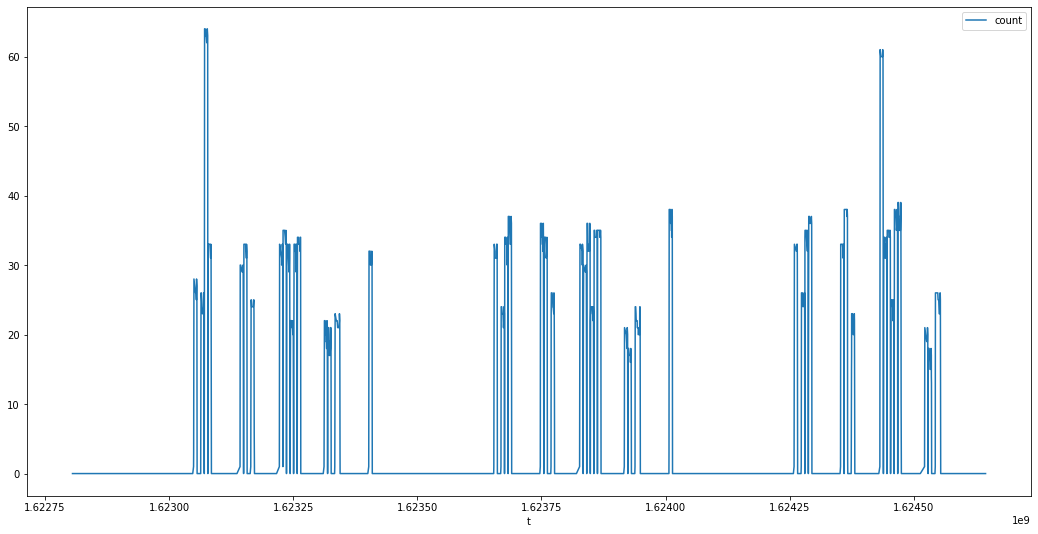

In [4]:
ts.plot(x=TIME_COLUMN, y=y_column, figsize=(18, 9))
plt.show()

In [5]:
# Inject some anomalies at the weekend
ts.loc[ts.index[44:49], y_column] = [1, 2, 3, 2, 1]
ts["is_anomaly"] = np.int64(0)
# Any count bigger than 0 at the weekends is anomaly
ts.loc[(ts.index.weekday >= 5) & (ts[y_column] > 0), "is_anomaly"] = 1
# Anything over 45 is also an anomaly
ts.loc[ts[y_column] > 45, "is_anomaly"] = 1
a = ts.loc[ts["is_anomaly"] == 1, [TIME_COLUMN, y_column]]
outliers_fraction = a.shape[0] / ts.shape[0] + 1e-7

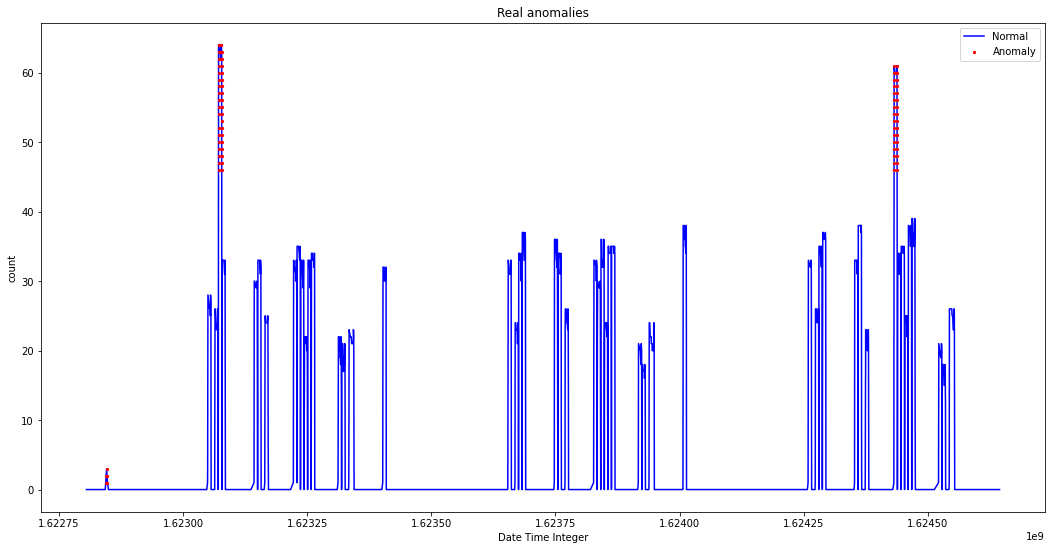

In [6]:
plot_anomalies(ts, a, y_column, "Real anomalies")

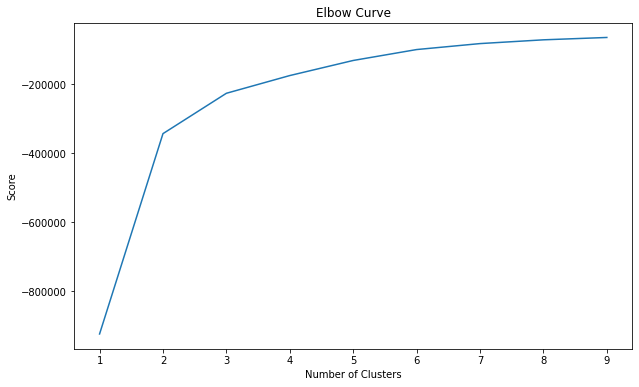

In [7]:
data = ts.loc[:, x_columns + [y_column]]
n_cluster = range(1, 10)
kmeans = [KMeans(n_clusters=i, n_init=20, max_iter=500).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Elbow Curve")
plt.show()

In [8]:
km = kmeans[6]

def getDistanceByPoint(data: pd.DataFrame, model: KMeans) -> pd.Series:
    distance = pd.Series(index=range(len(data)), dtype=DEFAULT_FLOAT_TYPE)
    for i in range(len(data)):
        Xa = np.array(data.iloc[i])
        Xb = model.cluster_centers_[model.labels_[i] - 1]
        distance.iat[i] = np.linalg.norm(Xa - Xb)
    return distance

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, km)
number_of_outliers = int(outliers_fraction * len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly)
ts["anomaly1"] = pd.Series((distance >= threshold).values, index=ts.index, dtype=np.int64)
a = ts.loc[ts["anomaly1"] == 1, [TIME_COLUMN, y_column]]

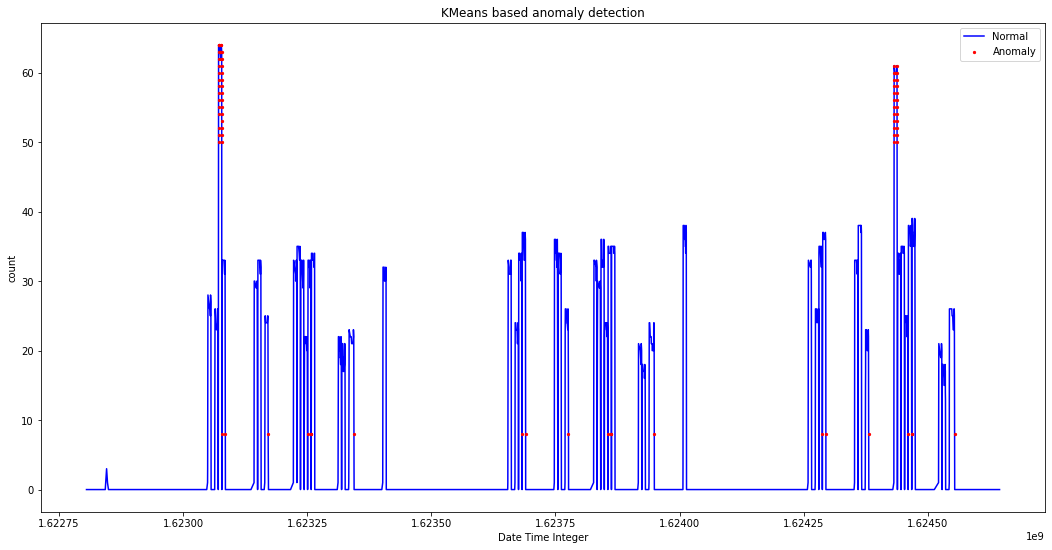

In [9]:
plot_anomalies(ts, a, y_column, "KMeans based anomaly detection")

In [10]:
data = ts.loc[:, x_columns + [y_column]]
scaler = StandardScaler()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data))
def objective_isolation_forest(trial: optuna.Trial) -> float:
    kwargs = {}
    kwargs["n_estimators"] = trial.suggest_int("n_estimators", 50, 500, 25)
    kwargs["max_samples"] = trial.suggest_uniform("max_samples", 0.0, 1.0)
    kwargs["max_features"] = trial.suggest_uniform("max_features", 0.0, 1.0)
    kwargs["bootstrap"] = trial.suggest_categorical("bootstrap", [False, True])
    kwargs["warm_start"] = trial.suggest_categorical("warm_start", [False, True])
    # train isolation forest
    model =  IsolationForest(contamination=outliers_fraction, **kwargs)
    model.fit(scaled_data)
    anomaly_pred = pd.Series(model.predict(scaled_data), index=ts.index, dtype=np.int64)
    # BEFORE: -1 means anomaly, 1 means normal. AFTER: 1 means anomaly, 0 means normal.
    anomaly_pred.replace({-1: 1, 1: 0}, inplace=True)
    return f1_score(ts["is_anomaly"].to_numpy(), anomaly_pred.to_numpy())

study = optuna.create_study(direction="maximize")
study.optimize(objective_isolation_forest, n_trials=100)
model = IsolationForest(contamination=outliers_fraction, **study.best_params)
model.fit(scaled_data)
ts["anomaly2"] = pd.Series(model.predict(scaled_data), index=ts.index, dtype=np.int64)
ts["anomaly2"].replace({-1: 1, 1: 0}, inplace=True)
a = ts.loc[ts["anomaly2"] == 1, [TIME_COLUMN, y_column]]

[I 2021-06-27 16:06:31,694] A new study created in memory with name: no-name-6864fff6-fff1-47eb-8395-ee03b50a457b
[I 2021-06-27 16:06:32,197] Trial 0 finished with value: 0.25882352941176473 and parameters: {'n_estimators': 200, 'max_samples': 0.9583902944570178, 'max_features': 0.19152450432878743, 'bootstrap': True, 'warm_start': False}. Best is trial 0 with value: 0.25882352941176473.
[I 2021-06-27 16:06:33,165] Trial 1 finished with value: 0.511904761904762 and parameters: {'n_estimators': 325, 'max_samples': 0.4987020165896082, 'max_features': 0.5518589312815814, 'bootstrap': True, 'warm_start': False}. Best is trial 1 with value: 0.511904761904762.
[I 2021-06-27 16:06:33,599] Trial 2 finished with value: 0.36470588235294116 and parameters: {'n_estimators': 175, 'max_samples': 0.4748140935616849, 'max_features': 0.1855260883687, 'bootstrap': True, 'warm_start': True}. Best is trial 1 with value: 0.511904761904762.
[I 2021-06-27 16:06:33,988] Trial 3 finished with value: 0.52694610

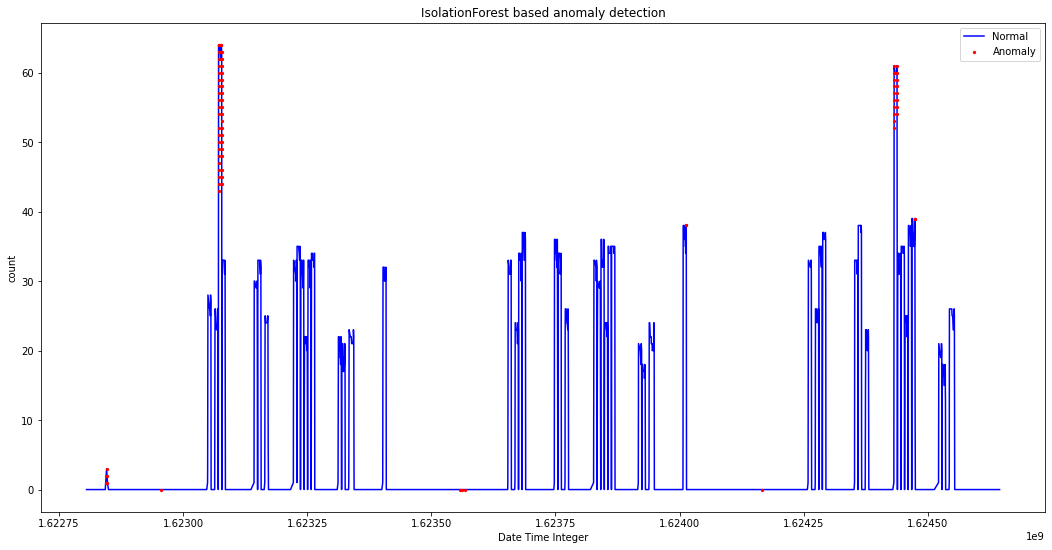

In [11]:
plot_anomalies(ts, a, y_column, "IsolationForest based anomaly detection")

In [12]:
data = ts.loc[:, x_columns + [y_column]]
scaler = StandardScaler()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data))
def objective_oneclass_svm(trial: optuna.Trial) -> float:
    kwargs = {}
    kwargs["kernel"] = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    if kwargs["kernel"] == "poly":
        kwargs["degree"] = trial.suggest_int("degree", 1, 5)
    kwargs["shrinking"] = trial.suggest_categorical("shrinking", [False, True])
    # train oneclassSVM
    model = OneClassSVM(nu=outliers_fraction, tol=1e-4, **kwargs)
    model.fit(scaled_data)
    anomaly_pred = pd.Series(model.predict(scaled_data), index=ts.index, dtype=np.int64)
    # BEFORE: -1 means anomaly, 1 means normal. AFTER: 1 means anomaly, 0 means normal.
    anomaly_pred.replace({-1: 1, 1: 0}, inplace=True)
    return f1_score(ts["is_anomaly"].to_numpy(), anomaly_pred.to_numpy())

study = optuna.create_study(direction="maximize")
study.optimize(objective_oneclass_svm, n_trials=50)
model = OneClassSVM(nu=outliers_fraction, **study.best_params)
model.fit(scaled_data)
ts["anomaly3"] = pd.Series(model.predict(scaled_data), index=ts.index, dtype=np.int64)
# BEFORE: -1 means anomaly, 1 means normal. AFTER: 1 means anomaly, 0 means normal.
ts["anomaly3"].replace({-1: 1, 1: 0}, inplace=True)
a = ts.loc[ts["anomaly3"] == 1, [TIME_COLUMN, y_column]]

[I 2021-06-27 16:07:23,876] A new study created in memory with name: no-name-63760559-abbf-4227-90ec-f162d6769346
[I 2021-06-27 16:07:23,903] Trial 0 finished with value: 0.0 and parameters: {'kernel': 'poly', 'degree': 1, 'shrinking': False}. Best is trial 0 with value: 0.0.
[I 2021-06-27 16:07:23,996] Trial 1 finished with value: 0.0 and parameters: {'kernel': 'poly', 'degree': 5, 'shrinking': True}. Best is trial 0 with value: 0.0.
[I 2021-06-27 16:07:24,029] Trial 2 finished with value: 0.0 and parameters: {'kernel': 'poly', 'degree': 4, 'shrinking': False}. Best is trial 0 with value: 0.0.
[I 2021-06-27 16:07:24,054] Trial 3 finished with value: 0.0 and parameters: {'kernel': 'linear', 'shrinking': True}. Best is trial 0 with value: 0.0.
[I 2021-06-27 16:07:24,096] Trial 4 finished with value: 0.0 and parameters: {'kernel': 'poly', 'degree': 3, 'shrinking': False}. Best is trial 0 with value: 0.0.
[I 2021-06-27 16:07:24,150] Trial 5 finished with value: 0.3668639053254437 and para

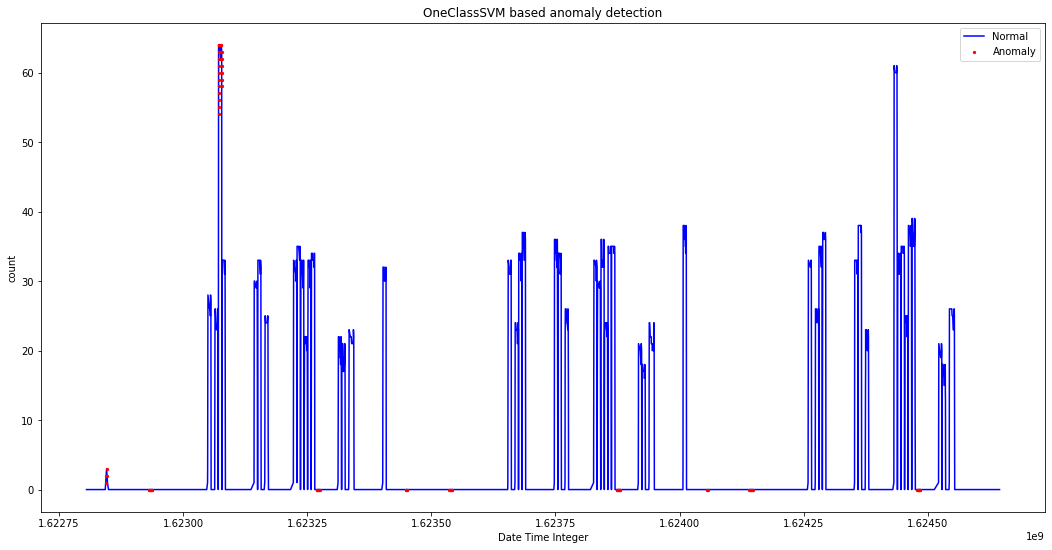

In [13]:
plot_anomalies(ts, a, y_column, "OneClassSVM based anomaly detection")